# Monte Carlo Markov Chain sampling of COVID-19 infections

#### Author: leebond
#### Date: Feb 2020

In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os, re, sys

# from helper_fun_model import *
from mcmcHelperFunctions import *

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Data source
#### source JHU

In [2]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv")

"""
Data Cleaning 
"""
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
df.tail(3) # check new

,Province,Country,Date,Confirmed,Deaths,Recovered
2115,"San Antonio, TX",US,2020-02-22,1.0,0,0
2116,"Seattle, WA",US,2020-02-22,1.0,0,1
2117,"Tempe, AZ",US,2020-02-22,1.0,0,0


# Case 1: Simulate China infection numbers

In [3]:
case = df[df['Country']=='China'] # get all of China's infection numbers
case = case.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

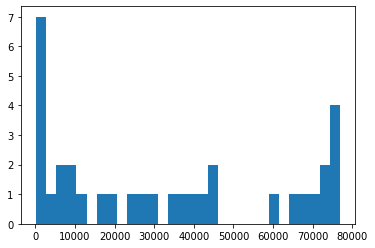

In [4]:
plt.hist(case['Confirmed'], bins = 30)
plt.show()

#### Using the daily change in infection number as a random variable we want to model
- the change in the infection numbers from day to day can tell us the force of infection per day. In other words, it can also be thought of as the infection rate which we could model as a random variable.
- to do so i simply do `diff()` which takes the first 'lag' of the infection column. Notice that the first row will not have any number since there is no 'lag'. Therefore, I fill the first record as 1 for simplicity yet it can't be 0 since there 'should' be some kind of new infection from day to day.

In [5]:
case['new infected'] = case['Confirmed'].diff().fillna(1)

In [6]:
case.head(10)

,Date,Confirmed,Deaths,Recovered,new infected
0,2020-01-20,144.0,0,0,1.0
1,2020-01-21,217.0,0,0,73.0
2,2020-01-22,547.0,17,28,330.0
3,2020-01-23,639.0,18,30,92.0
4,2020-01-24,916.0,26,36,277.0
5,2020-01-25,1399.0,42,39,483.0
6,2020-01-26,2062.0,56,49,663.0
7,2020-01-27,2863.0,82,58,801.0
8,2020-01-28,5494.0,131,101,2631.0
9,2020-01-29,6070.0,133,120,576.0


In [8]:
case.shape

(34, 5)

## EDA

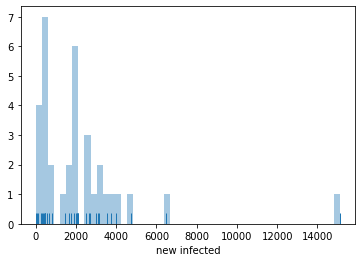

In [9]:
sb.distplot(case['new infected'], bins=50, kde=False, rug=True)

### Creating a gamma fit to the data
- the belief distribution is that the infection rate follows a gamma distribution.
- A gamma distribution is continuous, does not take on negative values and its flexible since it takes on two parameters; shape and scale
- several research papers have used gamma to model infection rates (google abit and you will see many using gamma)

In [10]:
mu = case['new infected'].mean()
sigma = case['new infected'].std()
mu, sigma

(2258.205882352941, 2733.5506799699815)

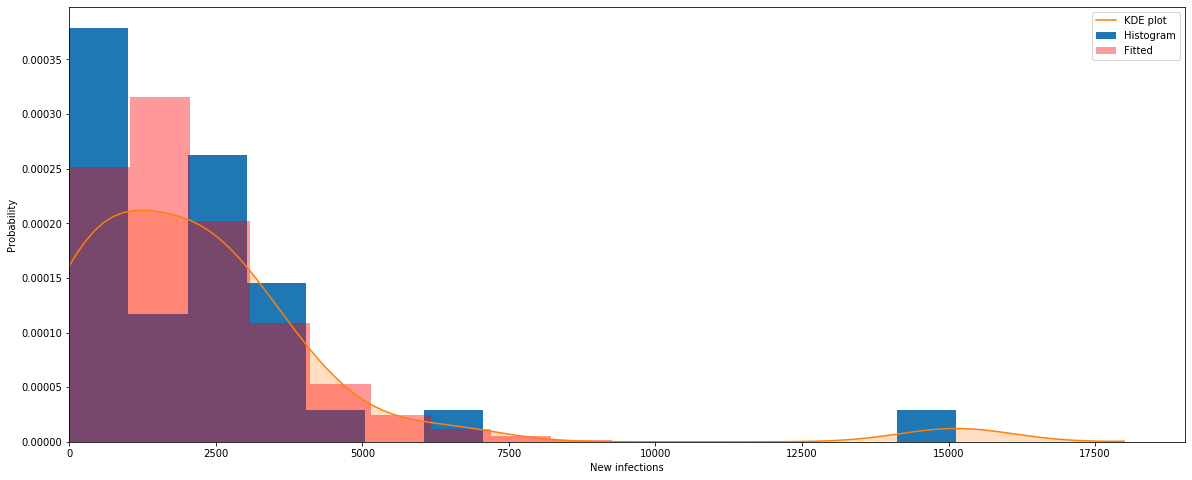

In [11]:
shape, scale = 2, 1050 # manual
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case['new infected'], bins=15, normed=True, label='Histogram')
sb.kdeplot(case['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=15, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Some comments about the fitting
- The density plot is **missing some data** because we did not include counts from the earlier days of the outbreak (we have it but it is highly unreliable) 
- therefore the density distribution do not have new infection numbers that is near 0

#### Kolmogorov-Smirnov test for goodness of fit

In [12]:
from scipy.stats import kstest
kstest(case['new infected'], 'norm', args=[shape,scale])

KstestResult(statistic=0.5337070226239256, pvalue=1.4201126232097264e-09)

# MCMC
- Why MCMC?
 - it offers us a robust method to draw samples from our posterior ie. allow us to bootstrap our data (new infection) to test a distribution
 - with the sampled distribution we can use MLE to find the parameters of the distribution
 - since our belief is a gamma distribution, we do the MLE for gamma
 - with the shape and scale parameters of gamma, we create an actual gamma distribution with these parameters, allowing us to forecast/predict samples that fall within the distribution of gamma. 
 - we do not know exactly what tomorrow's new infection number will be. But we can know the mean and variance of the gamma distribution + today's infection number = gives us tomorrow's infection count. 
 - Yes, it doesn't tell us in the future when and what the infection count will be (it doesnt forecast).

### Description
- MCMC
- use Metropolis Hastings' acceptance criterion
- checks for convergence using Gelman-Rubin's ratio

iter: 25000.0
Theta: 1000
Mean of samples: 2221.087873543672, Stddev of samples: 1607.913497136522
Theta: 1500
Mean of samples: 1619.736402607194, Stddev of samples: 950.5047047687431
Theta: 2000
Mean of samples: 1723.2667290120635, Stddev of samples: 990.7928993146601
Theta: 2500
Mean of samples: 2214.629112401015, Stddev of samples: 1683.5272962137199
Theta: 3000
Mean of samples: 2628.195846570029, Stddev of samples: 1742.2621204620052
Gelman Rubin convergence ratio: 1.235261164188785
iter: 62500.0
Theta: 1000
Mean of samples: 2088.491440344438, Stddev of samples: 1339.85051756821
Theta: 1500
Mean of samples: 2474.8522780890203, Stddev of samples: 1890.29103814353
Theta: 2000
Mean of samples: 1928.004155911553, Stddev of samples: 1221.948593599289
Theta: 2500
Mean of samples: 2210.694951959837, Stddev of samples: 1496.9857891008337
Theta: 3000
Mean of samples: 2396.394860557178, Stddev of samples: 1853.6019019242551
Gelman Rubin convergence ratio: 1.2017129008665086
iter: 100000.0
Th

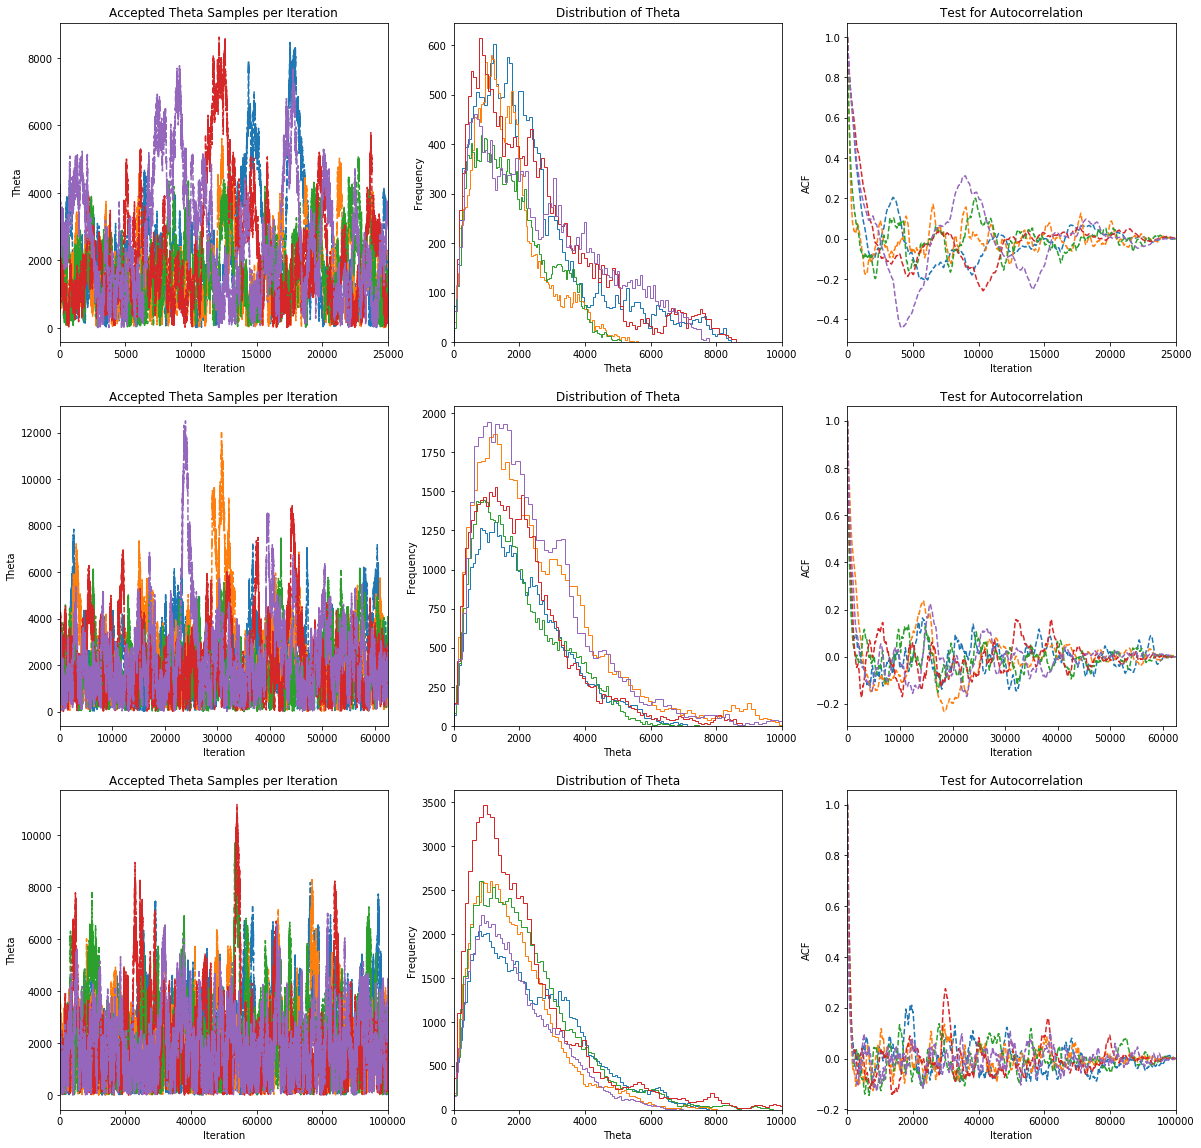

Wall time: 5min 52s


In [13]:
%%time
mcmc_samples = MCMC(shape, scale, niters = np.linspace(25e3,1e5,3), thetas = np.arange(1000, 3500, 500))

#### Result of MCMC Samples

In [14]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 2.1, Beta: 990.3
Mean infection count: 2114.9


## Case 2: Simulate Hubei infection numbers

In [15]:
case_hubei = df[df['Province']=='Hubei']

In [16]:
case_hubei.head(10)

,Province,Country,Date,Confirmed,Deaths,Recovered
0,Hubei,China,2020-01-20,136.0,0,0
6,Hubei,China,2020-01-21,209.0,0,0
21,Hubei,China,2020-01-22,444.0,17,28
59,Hubei,China,2020-01-23,444.0,17,28
92,Hubei,China,2020-01-24,549.0,24,31
133,Hubei,China,2020-01-25,761.0,40,32
177,Hubei,China,2020-01-26,1058.0,52,42
224,Hubei,China,2020-01-27,1423.0,76,45
275,Hubei,China,2020-01-28,3554.0,125,80
327,Hubei,China,2020-01-29,3554.0,125,88


In [17]:
case_hubei['new infected'] = case_hubei['Confirmed'].diff().fillna(1)

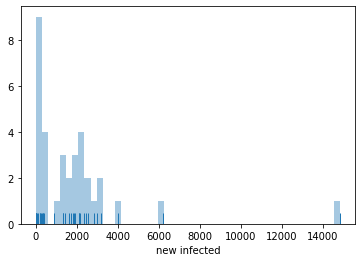

In [18]:
sb.distplot(case_hubei['new infected'], bins=50, kde=False, rug=True)

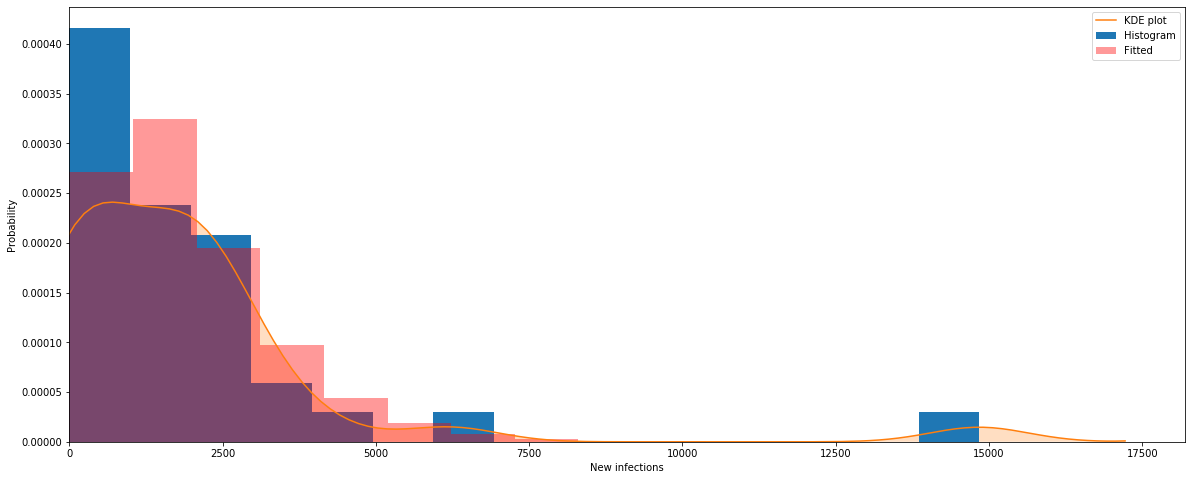

In [43]:
shape, scale = 2, 1000 # manual
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case_hubei['new infected'], bins=15, normed=True, label='Histogram')
sb.kdeplot(case_hubei['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=15, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Kolmogorov-Smirnov test for goodness of fit

In [44]:
from scipy.stats import kstest
kstest(case_hubei['new infected'], 'norm', args=[shape,scale])

KstestResult(statistic=0.49920211597111985, pvalue=2.3365326769839174e-08)

In [26]:
mu = case_hubei['new infected'].mean()
sigma = case_hubei['new infected'].std()
mu, sigma

(1880.8529411764705, 2674.6324259759504)

iter: 25000.0
Theta: 1500
Mean of samples: 1595.835426200734, Stddev of samples: 1205.0021776225012
Theta: 2000
Mean of samples: 1435.3190139056414, Stddev of samples: 1057.1430003238695
Theta: 2500
Mean of samples: 1466.1865448450956, Stddev of samples: 1190.400065283356
Theta: 3000
Mean of samples: 1528.744012900018, Stddev of samples: 1245.766027113599
Theta: 3500
Mean of samples: 1452.893348649374, Stddev of samples: 1124.6495137561878
Gelman Rubin convergence ratio: 1.1862691672243568
iter: 62500.0
Theta: 1500
Mean of samples: 1520.674203299486, Stddev of samples: 1143.1100577676953
Theta: 2000
Mean of samples: 1561.2381833184363, Stddev of samples: 1251.5268744368664
Theta: 2500
Mean of samples: 1461.2151120390083, Stddev of samples: 1107.6446219562363
Theta: 3000
Mean of samples: 1594.1028639216734, Stddev of samples: 1274.105839328854
Theta: 3500
Mean of samples: 1480.2163926126416, Stddev of samples: 1076.8990725063197
Gelman Rubin convergence ratio: 1.185414310485562
iter: 10

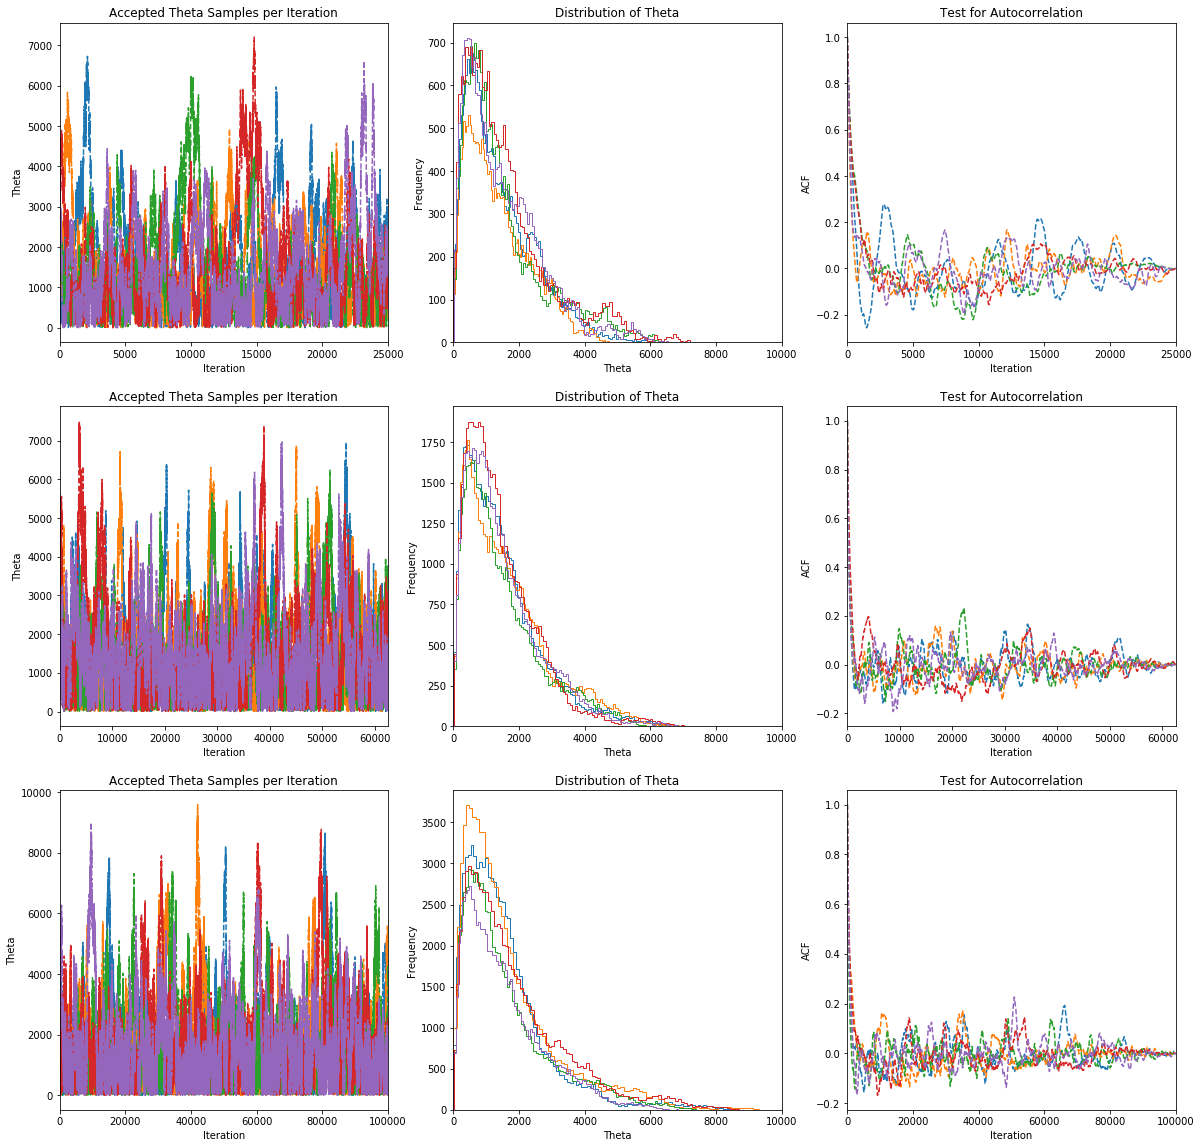

Wall time: 5min 50s


In [27]:
%%time
mcmc_samples = MCMC(shape, scale, niters = np.linspace(25e3,1e5,3), thetas = np.arange(1500, 3501, 500))

#### Result of MCMC Samples

In [28]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 1.5, Beta: 1085.6
Mean infection count: 1663.2


## Case 3: Simulate China, ex-Hubei infection numbers

In [29]:
case_exHubei = df[(df['Country']=='China')&(df['Province']!='Hubei')]

In [30]:
case_exHubei = case_exHubei.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [31]:
case_exHubei['new infected'] = case_exHubei['Confirmed'].diff().fillna(1)

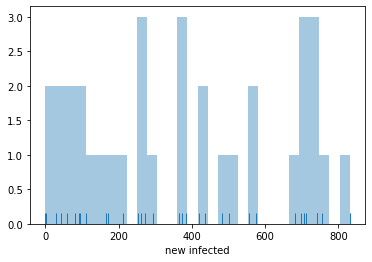

In [32]:
sb.distplot(case_exHubei['new infected'], bins=30, kde=False, rug=True)

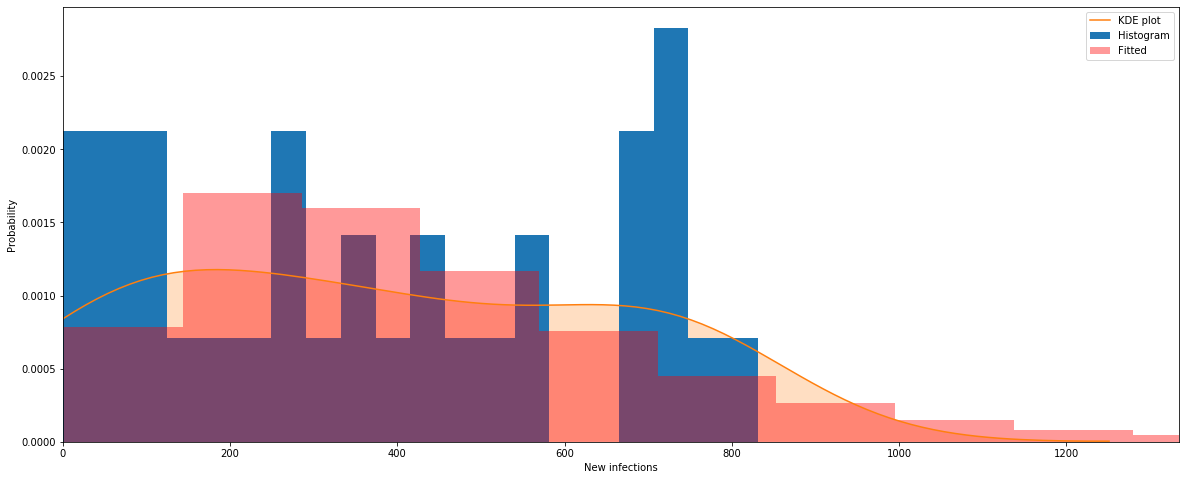

In [64]:
shape, scale = 2.4, 180 # manual
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case_exHubei['new infected'], bins=20, normed=True, label='Histogram')
sb.kdeplot(case_exHubei['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=20, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Kolmogorov-Smirnov test for goodness of fit

In [67]:
from scipy.stats import kstest
kstest(case_exHubei['new infected'], 'norm', args=[shape,scale])

KstestResult(statistic=0.5651312657912482, pvalue=8.852997395313925e-11)

In [65]:
mu = case_exHubei['new infected'].mean()
sigma = case_exHubei['new infected'].std()
mu, sigma

(377.38235294117646, 267.68129112535735)

iter: 25000.0
Theta: 100
Mean of samples: 440.85386737032786, Stddev of samples: 283.02831166291736
Theta: 600
Mean of samples: 488.62568483920603, Stddev of samples: 294.4272360793127
Theta: 1100
Mean of samples: 394.3834899797217, Stddev of samples: 262.92285449182214
Theta: 1600
Mean of samples: 370.8299991174251, Stddev of samples: 221.98534545941538
Theta: 2100
Mean of samples: 477.5341915804332, Stddev of samples: 374.4225051510074
Gelman Rubin convergence ratio: 1.2056056575691412
iter: 62500.0
Theta: 100
Mean of samples: 387.88926923259413, Stddev of samples: 224.16588825354728
Theta: 600
Mean of samples: 394.70145448029245, Stddev of samples: 223.07834189016327
Theta: 1100
Mean of samples: 422.12321217026323, Stddev of samples: 274.96517113444
Theta: 1600
Mean of samples: 427.4424956623108, Stddev of samples: 275.25504272070145
Theta: 2100
Mean of samples: 435.2932806203699, Stddev of samples: 317.17897838240134
Gelman Rubin convergence ratio: 1.1853914457084922
iter: 100000.0

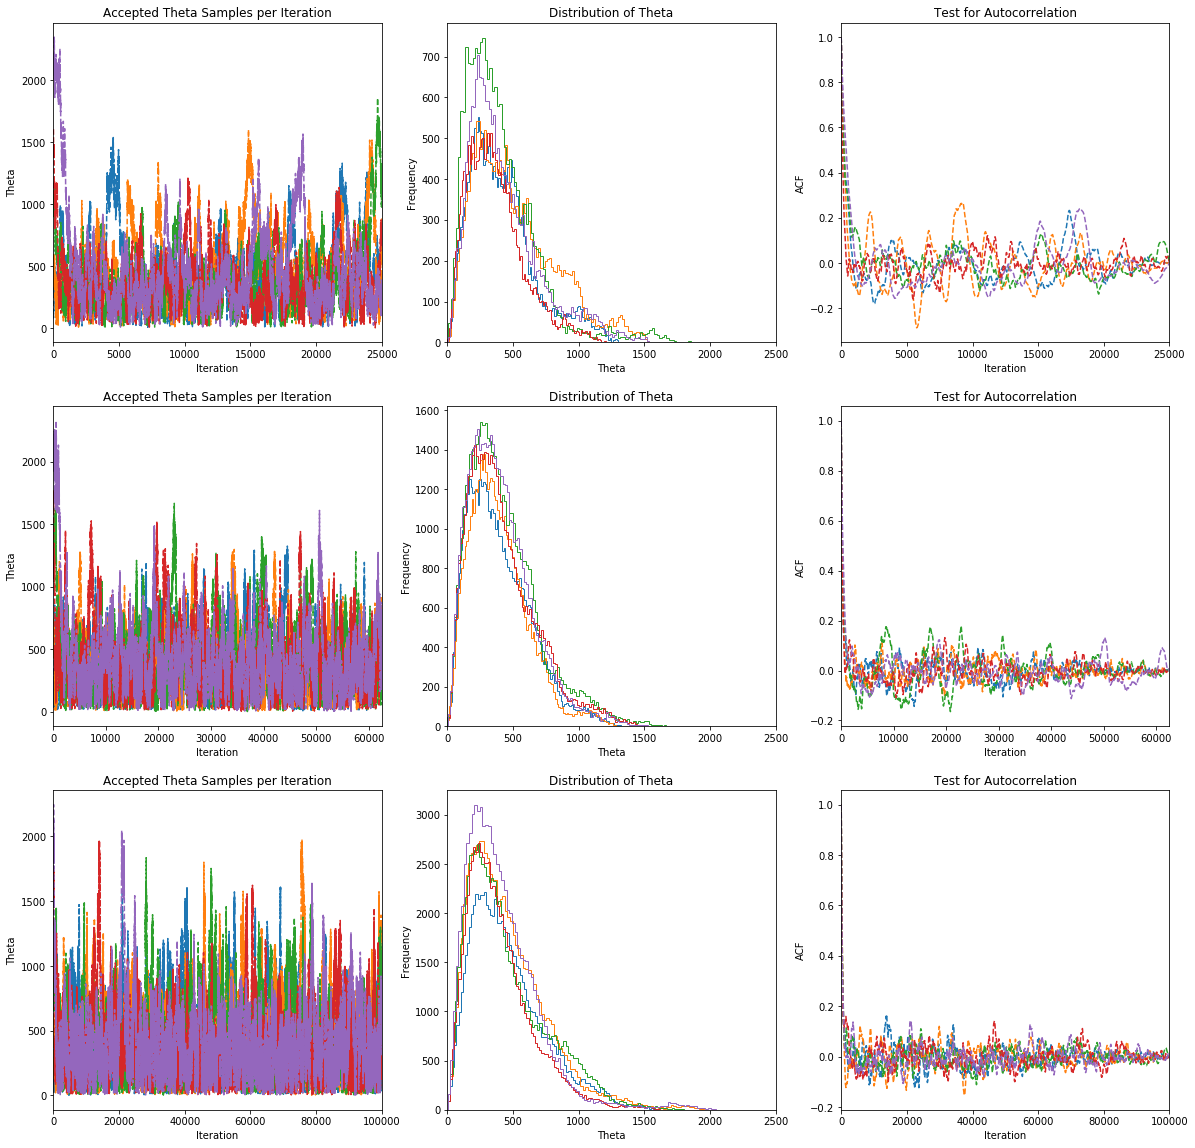

Wall time: 6min 8s


In [66]:
%%time
mcmc_samples = MCMC(shape, scale, sigma=25, niters = np.linspace(25e3,1e5,3), thetas = np.arange(100, 2101, 500))

### Result of MCMC Samples

In [68]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 2.5, Beta: 178.2
Mean infection count: 441.0


## Case 4: Simulate ex-China infection numbers

In [69]:
case_exChina = df[(df['Country']!='China')]

In [70]:
case_exChina = case_exChina.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [71]:
case_exChina['new infected'] = case_exChina['Confirmed'].diff().fillna(1)

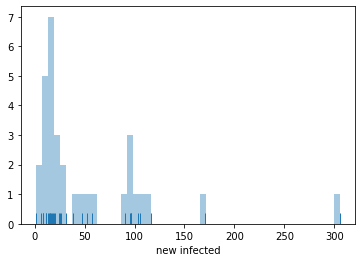

In [72]:
sb.distplot(case_exChina['new infected'], bins=50, kde=False, rug=True)

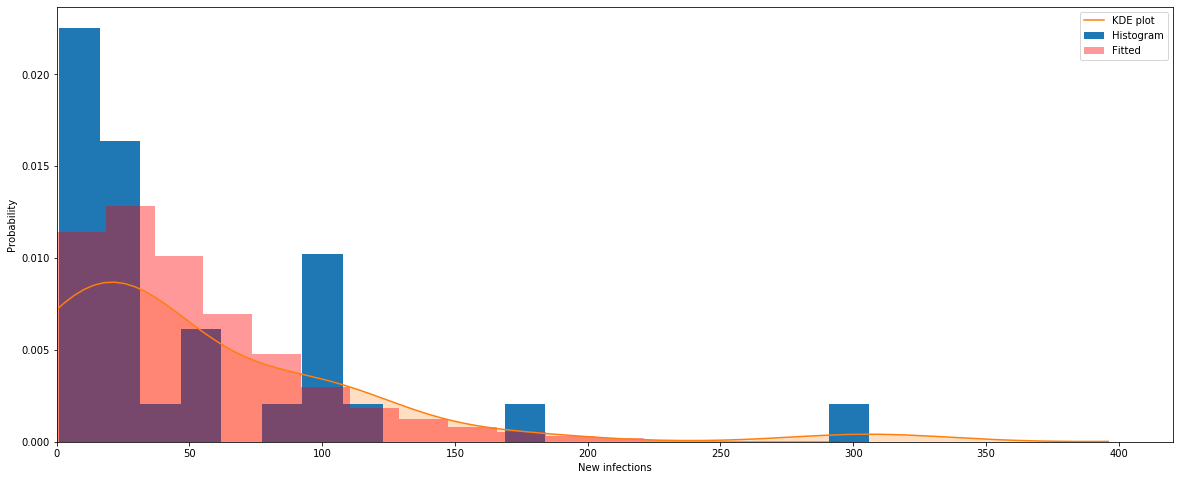

In [75]:
shape, scale = 1.5, 35 # manual
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case_exChina['new infected'], bins=20, normed=True, label='Histogram')
sb.kdeplot(case_exChina['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=20, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Kolmogorov-Smirnov test for goodness of fit

In [76]:
from scipy.stats import kstest
kstest(case_exHubei['new infected'], 'norm', args=[shape,scale])

KstestResult(statistic=0.8422170664489124, pvalue=1.3076579571319646e-27)

In [77]:
mu = case_exChina['new infected'].mean()
sigma = case_exChina['new infected'].std()
mu, sigma

(52.1875, 62.64772863580775)

iter: 25000.0
Theta: 1
Mean of samples: 54.79993433609144, Stddev of samples: 42.07693396307623
Theta: 21
Mean of samples: 56.092920488429506, Stddev of samples: 43.6079350249862
Theta: 41
Mean of samples: 52.98485485412065, Stddev of samples: 38.47747949173393
Theta: 61
Mean of samples: 56.233752221782794, Stddev of samples: 46.57362194031771
Theta: 81
Mean of samples: 47.42470741265343, Stddev of samples: 33.894486539349245
Gelman Rubin convergence ratio: 1.1862400584986699
iter: 62500.0
Theta: 1
Mean of samples: 52.97435803810834, Stddev of samples: 40.29191242418161
Theta: 21
Mean of samples: 55.81305141871223, Stddev of samples: 43.60636738956371
Theta: 41
Mean of samples: 53.86247242737294, Stddev of samples: 42.71272828786665
Theta: 61
Mean of samples: 58.80419886471539, Stddev of samples: 47.21697633992422
Theta: 81
Mean of samples: 53.33156769313665, Stddev of samples: 43.027047171637996
Gelman Rubin convergence ratio: 1.1863940921912275
iter: 100000.0
Theta: 1
Mean of samples

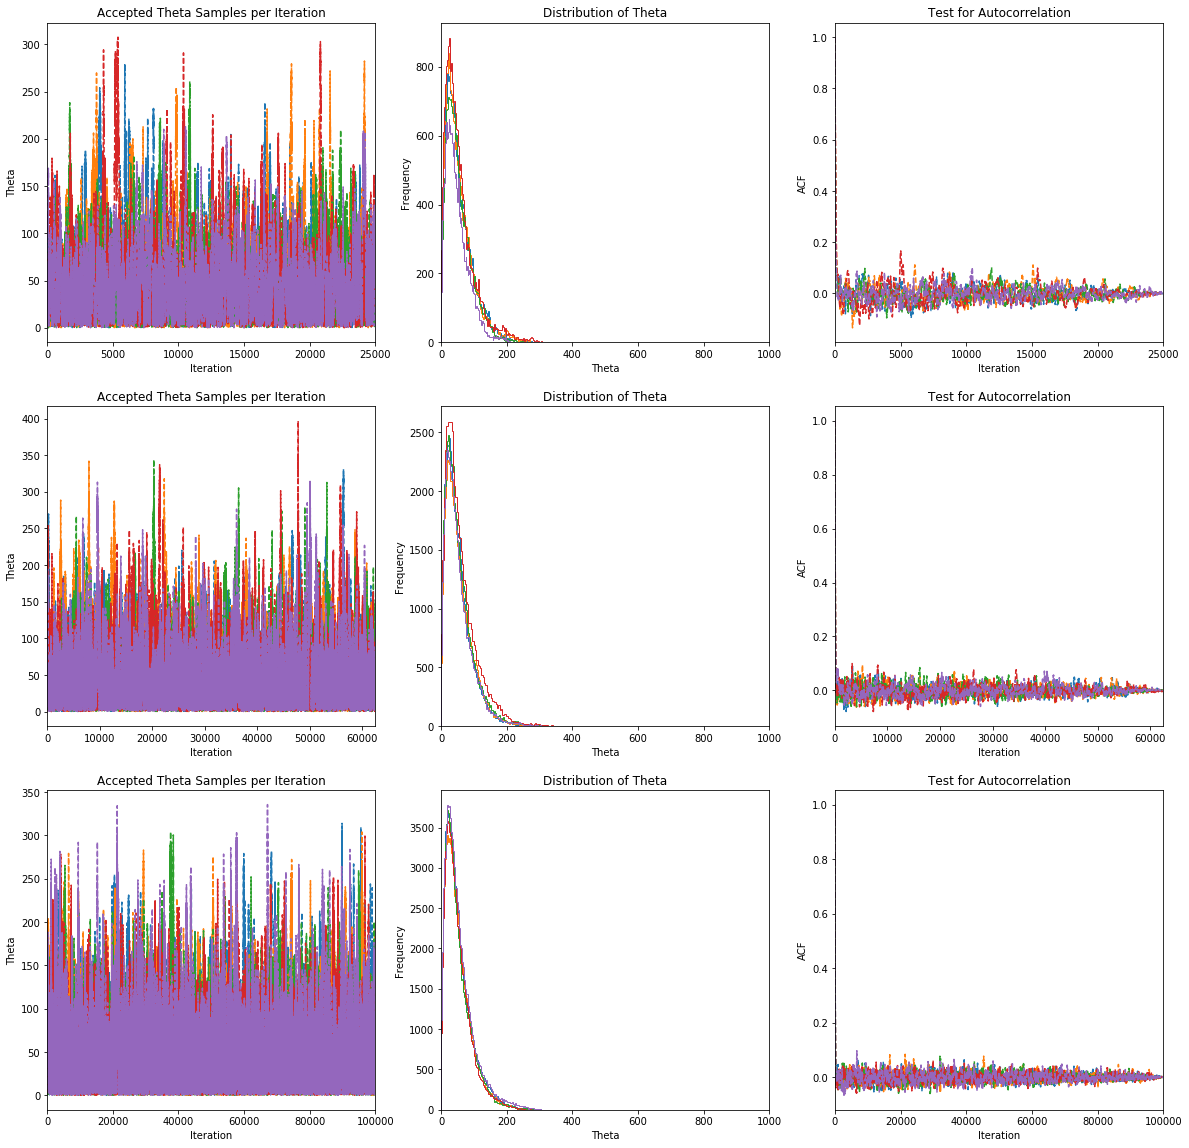

Wall time: 7min 21s


In [79]:
%%time
mcmc_samples = MCMC(shape, scale, sigma=10, niters = np.linspace(25e3,1e5,3), thetas = np.arange(1, 101, 20))

## Result of MCMC Samples

In [80]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))

Alpha: 1.7, Beta: 31.9
Mean infection count: 53.4
